In [20]:
% matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.linalg as sl
import os

import libstempo as libs
import libstempo.plot as libsplt

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [59]:
savetime = True

In [62]:
datadir = os.getcwd() + '/mdc2/group1/dataset_1b'
savedir = os.getcwd() + '/mdc2/group1/dataset_1b_correctedpars/'

orig_parfiles = sorted(glob.glob(datadir + '/*.par'))
orig_timfiles = sorted(glob.glob(datadir + '/*.tim'))

parfile_J0030 = datadir + '/J0030+0451.par'
timfile_J0030 = datadir + '/J0030+0451.tim'

In [65]:
#Load Pulsar into enterprise
psr_J0030 = Pulsar(parfile_J0030,timfile_J0030)
#Load Pulsar into libstempo
libs_psr_J0030 = libs.tempopulsar(parfile = parfile_J0030,timfile = timfile_J0030)

In [66]:
#All of the Pulsars!
orig_libs_psrs = []
for p, t in zip(orig_parfiles, orig_timfiles):
    orig_libs_psr = libs.tempopulsar(p, t)
    orig_libs_psrs.append(orig_libs_psr)

In [67]:
#Fit the par files again
#Save them to new directory (Overwrites ones currently used in savedir)
for orig_libs_psr in orig_libs_psrs:
    orig_libs_psr.fit()
    if savetime == True:
        #print(savedir + libs_psr.name + '.par')
        orig_libs_psr.savepar(savedir + orig_libs_psr.name + '.par')
        orig_libs_psr.savetim(savedir + orig_libs_psr.name + '.tim')

In [68]:
#Check new residuals
fit_parfiles = sorted(glob.glob(savedir + '/*.par'))
fit_timfiles = sorted(glob.glob(savedir + '/*.tim'))

fit_libs_psrs = []
for p, t in zip(fit_parfiles, fit_timfiles):
    fit_libs_psr = libs.tempopulsar(p, t)
    fit_libs_psrs.append(fit_libs_psr)

33


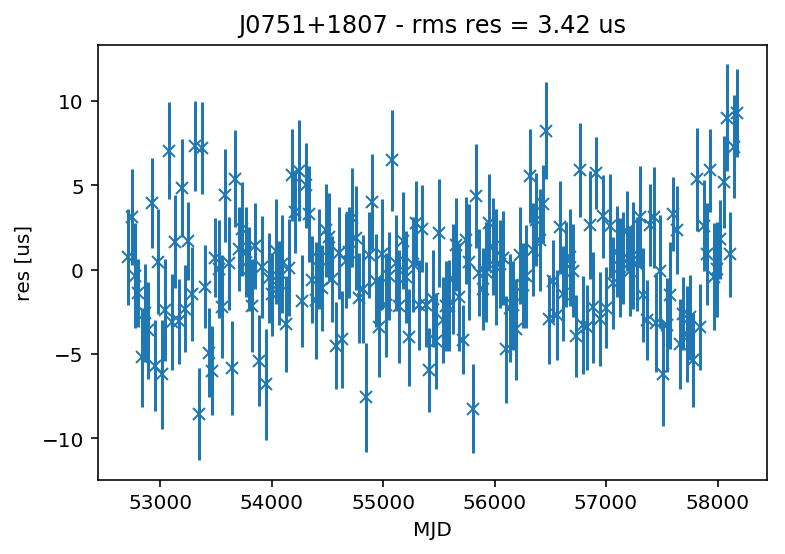

In [45]:
libsplt.plotres(libs_psrs[7])

In [8]:
##### parameters and priors #####

# Uniform prior on EFAC and EQUAD
efac = parameter.Uniform(0.1, 5.0)
log10_equad = parameter.Uniform(-10.0,-4.0)

# red noise parameters
# Uniform in log10 Amplitude and in spectral index
log10_A = parameter.Uniform(-18,-12)
gamma = parameter.Uniform(0,7)

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.EquadNoise(log10_equad = log10_equad)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30)

# timing model
tm = gp_signals.TimingModel()

# full model is sum of components
model = ef + rn + tm + eq

# initialize PTA
pta = signal_base.PTA([model(psr_J0030)])
print(pta.params)

[J0030+0451_efac:Uniform(pmin=0.1, pmax=5.0), J0030+0451_gamma:Uniform(pmin=0, pmax=7), J0030+0451_log10_A:Uniform(pmin=-18, pmax=-12), J0030+0451_log10_equad:Uniform(pmin=-10.0, pmax=-4.0)]


In [9]:
#Pick random initial sampling
xs = {par.name: par.sample() for par in pta.params}
print(xs)

{'J0030+0451_efac': 2.219356842855534, 'J0030+0451_gamma': 2.7893429728263617, 'J0030+0451_log10_A': -14.444007286237685, 'J0030+0451_log10_equad': -9.735795232386074}


In [10]:
# dimension of parameter space
ndim = len(xs)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups
ndim = len(xs)
groups  = [range(0, ndim)]
groups.extend([[2,3]])

# intialize sampler
#NEED TO CHANGE OUTDIR FILE ON DIFFERENT RUNS
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, outDir='chains/mdc/open1/')

In [11]:
# sampler for N steps
N = 100000
x0 = np.hstack(p.sample() for p in pta.params)
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

/anaconda3/envs/enterprise/lib/python3.6/site-packages/enterprise/signals/parameter.py:55: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 10.00 percent in 20.379956 s Acceptance rate = 0.50084Adding DE jump with weight 50
Finished 99.00 percent in 163.745092 s Acceptance rate = 0.456131
Run Complete


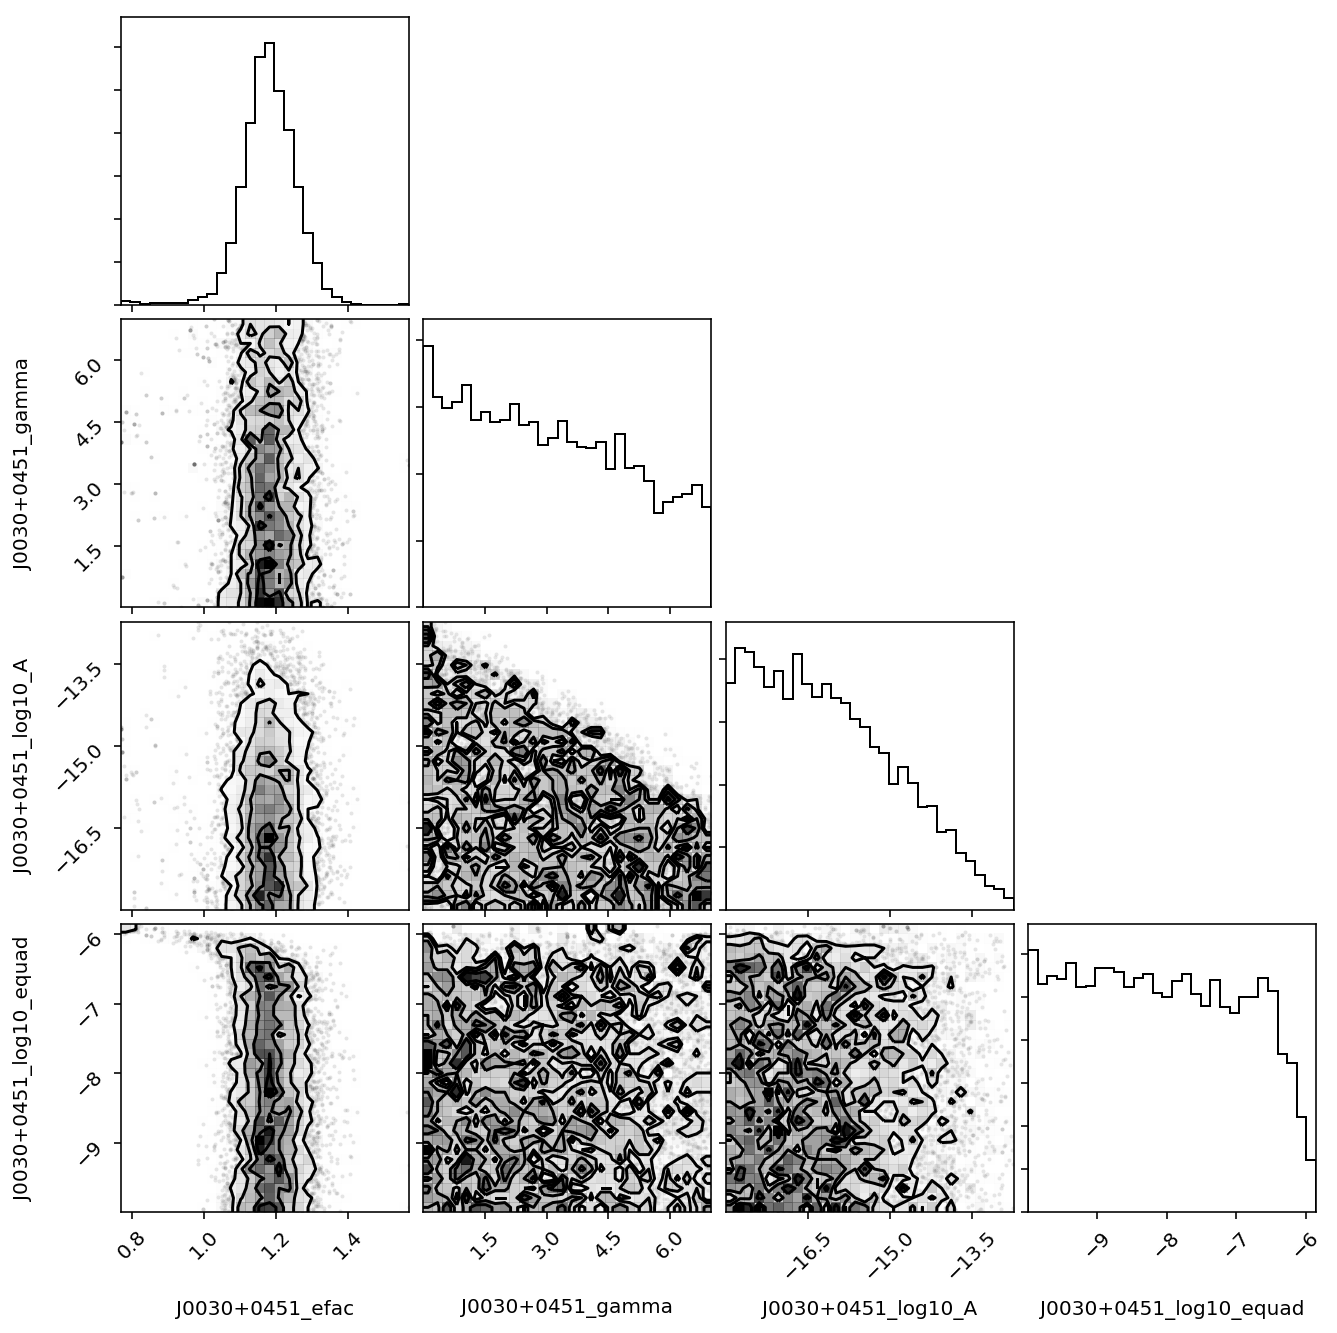

In [12]:
chain = np.loadtxt('chains/mdc/open1/chain_1.txt')
pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0])

truths = [1.0, 4.33, np.log10(5e-14)]
corner.corner(chain[burn:,:-4], 30, labels=pars);